# RNNs for Timeseries Analysis
# Simple Recurrent Neural Networks

In [2]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



# Load dataset

In [5]:
dataset = pd.read_csv("C:/Users/HP/Downloads/GDP.csv", header=0, parse_dates=[0], index_col=0)
dataset.head()

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


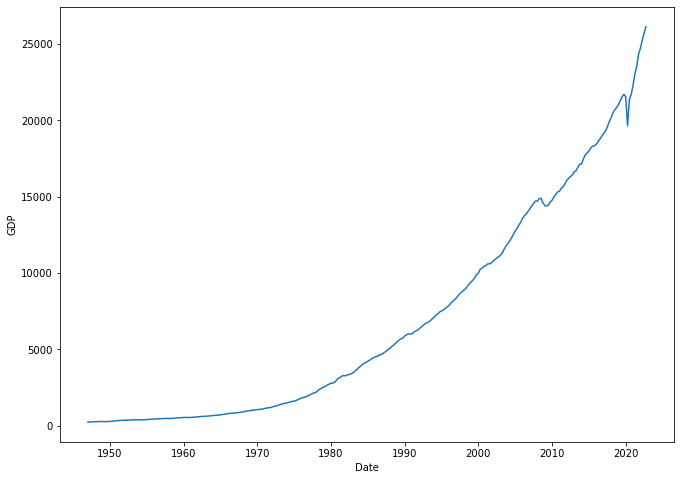

In [8]:
plt.plot(dataset['GDP'])
plt.xlabel('Date')
plt.ylabel('GDP');
plt.gcf().set_size_inches(11,8)

# Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [9]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1,1)
dataset.loc[1:, 'diff']=series

C:\Users\HP\AppData\Local\Temp\ipykernel_18376\4092678654.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[1:, 'diff']=series


In [10]:
dataset

,GDP,diff
DATE,,
1947-01-01,243.164,0.000000
1947-04-01,245.968,0.011531
1947-07-01,249.585,0.014705
1947-10-01,259.745,0.040708
1948-01-01,265.742,0.023088
...,...,...
2021-10-01,24349.121,0.033915
2022-01-01,24740.480,0.016073
2022-04-01,25248.476,0.020533


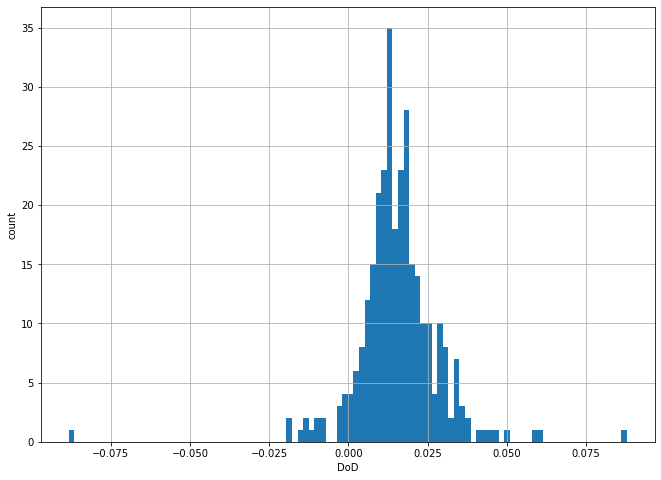

In [11]:
dataset['diff'].hist(bins=100)
plt.xlabel('DoD')
plt.ylabel('count')
plt.gcf().set_size_inches(11, 8)

In [14]:
series.reshape(-1, 1)

array([[ 1.15313122e-02],
       [ 1.47051649e-02],
       [ 4.07075746e-02],
       [ 2.30880286e-02],
       [ 2.56828051e-02],
       [ 2.43206258e-02],
       [ 4.19060445e-03],
       [-1.90179979e-02],
       [-1.33910716e-02],
       [ 5.66793563e-03],
       [-8.28908457e-03],
       [ 3.76939478e-02],
       [ 3.40243850e-02],
       [ 6.11950424e-02],
       [ 3.82667052e-02],
       [ 5.01804998e-02],
       [ 2.40773810e-02],
       [ 2.12008486e-02],
       [ 1.36403091e-02],
       [ 1.02252245e-02],
       [ 3.36279251e-03],
       [ 1.84776888e-02],
       [ 3.56566885e-02],
       [ 1.88229363e-02],
       [ 9.71441827e-03],
       [-1.47543453e-03],
       [-1.32959754e-02],
       [-1.61929684e-03],
       [ 2.01377986e-03],
       [ 1.26255759e-02],
       [ 2.23480547e-02],
       [ 3.33696908e-02],
       [ 2.04782206e-02],
       [ 2.06129072e-02],
       [ 1.59708615e-02],
       [ 6.07194824e-03],
       [ 1.42445866e-02],
       [ 1.16163315e-02],
       [ 2.0

# Training and Testing datasets

In [15]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

array([[ 0.16919917],
       [ 0.46441687],
       [ 0.2643738 ],
       [ 0.29383353],
       [ 0.27836806],
       [ 0.04982237],
       [-0.21367591],
       [-0.14979075],
       [ 0.06659521],
       [-0.09186547],
       [ 0.43020173],
       [ 0.38853945],
       [ 0.69702082],
       [ 0.43670452],
       [ 0.57196749],
       [ 0.27560639],
       [ 0.24294775],
       [ 0.15710935],
       [ 0.11833628],
       [ 0.04042383],
       [ 0.21203042],
       [ 0.40707176],
       [ 0.21595018],
       [ 0.11253685],
       [-0.01450686],
       [-0.14871107],
       [-0.0161402 ],
       [ 0.02510785],
       [ 0.14558861],
       [ 0.25597252],
       [ 0.38110639],
       [ 0.23474341],
       [ 0.23627257],
       [ 0.18356922],
       [ 0.07118216],
       [ 0.16397   ],
       [ 0.13413017],
       [ 0.23555898],
       [ 0.23194579],
       [ 0.05652509],
       [ 0.18179784],
       [-0.10729105],
       [-0.17286432],
       [ 0.11001431],
       [ 0.3357202 ],
       [ 0

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [19]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 203 training points and 99 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly

In [21]:


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(203, 1, 1)
(99, 1, 1)


# Define the model architecture.
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [31]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [32]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Epoch 1/100
13/13 [==============================] - 2s 3ms/step - loss: 0.0213
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 10/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 11/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 12/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 13/100
13/13 [=================

# Make predictions

In [33]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


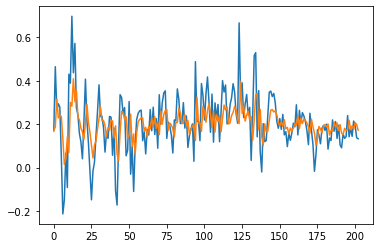

In [34]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

# Compute the actual values

In [35]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

C:\Users\HP\AppData\Local\Temp\ipykernel_18376\1280141578.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
C:\Users\HP\AppData\Local\Temp\ipykernel_18376\1280141578.py:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)


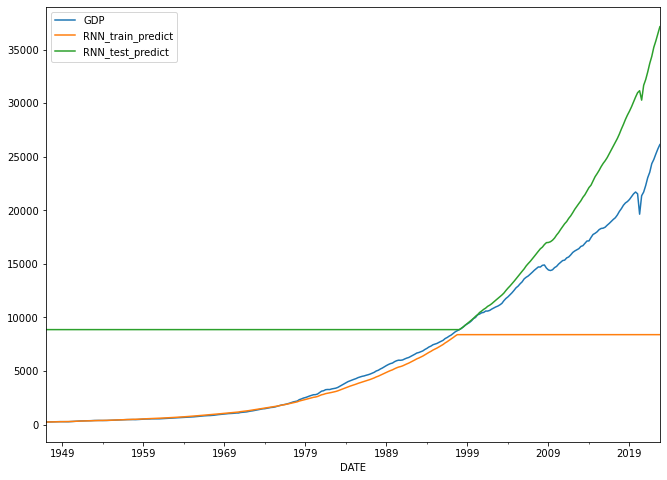

In [36]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# Thank you
## Author

<a href="https://www.linkedin.com/in/muhammad-bilal-afzal-95b33323b/">MUHAMMAD BILAL</a>